# **GTSF IC Quant Mentorship - Final Project**

#### <font color='red'>**Links to all references underneath subheadings**</font>

**Name:** Siri Munigunti


## **Importing Libraries and Stock Data**

In [796]:
! pip install numpy pandas matplotlib seaborn statsmodels scikit-learn yfinance pmdarima arch

In [797]:
# Imports for this project

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection  import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from pmdarima.arima import auto_arima
from arch import arch_model
from arch.__future__ import reindexing
import math
import yfinance as yf

## **Data Cleaning and Preprocessing**

In [799]:
# Importing 6 years of Nvida OHCLV stock data from Yahoo Finance (2019-current)

def import_stock_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    """Load stock data from Yahoo Finance into a pandas DataFrame.

    Args:
        ticker (str): Company ticker
        start_date (str): First date to collect data
        end_date (str): Last date to collect data

    Returns:
        pd.DataFrame: A DataFrame containing stock data.
    """
    
    ###########################
    df = yf.download(ticker, start=start_date, end=end_date)
    df.columns = df.columns.droplevel(level=1)
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    df = df.sort_values(by='Date')
    return df
    ###########################

#####################
nvda = import_stock_data('NVDA', '2019-01-01', '2025-04-20')[['Date', 'Close', 'Volume']]
print(nvda.head())
#####################

[*********************100%***********************]  1 of 1 completed

Price                      Date     Close     Volume
0     2019-01-02 00:00:00+00:00  3.377779  508752000
1     2019-01-03 00:00:00+00:00  3.173704  705552000
2     2019-01-04 00:00:00+00:00  3.377036  585620000
3     2019-01-07 00:00:00+00:00  3.555819  709160000
4     2019-01-08 00:00:00+00:00  3.467294  786016000


In [800]:
# Handling missing values, inconsistent formats, and structural issues

def cleanup_data(df: pd.DataFrame):
    """Cleanup stock data from a pandas DataFrame.

    Args:
        df (pd.DataFrame): A DataFrame containing stock data
    """
    
    df.dropna(inplace=True)
    print("Number of duplicates: ", df.duplicated().sum())
    df.info()

##############################
cleanup_data(nvda)
##############################

Number of duplicates:  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Date    1583 non-null   datetime64[ns, UTC]
 1   Close   1583 non-null   float64            
 2   Volume  1583 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(1)
memory usage: 37.2 KB


In [801]:
# Calculate daily % returns and log daily % returns.
# Create a new column in the dataframe for 'daily_returns' and 'log_daily_returns'. Use the 'Close' price column and compute percentage changes.

######################
nvda['daily_returns'] = nvda['Close'].pct_change()
nvda['log_daily_returns'] = np.log(nvda['Close'] / nvda['Close'].shift(1))
nvda = nvda.dropna()
nvda.head()
######################

Price,Date,Close,Volume,daily_returns,log_daily_returns
1,2019-01-03 00:00:00+00:00,3.173704,705552000,-0.060417,-0.062319
2,2019-01-04 00:00:00+00:00,3.377036,585620000,0.064068,0.062099
3,2019-01-07 00:00:00+00:00,3.555819,709160000,0.052941,0.051587
4,2019-01-08 00:00:00+00:00,3.467294,786016000,-0.024896,-0.025211
5,2019-01-09 00:00:00+00:00,3.535485,617260000,0.019667,0.019476


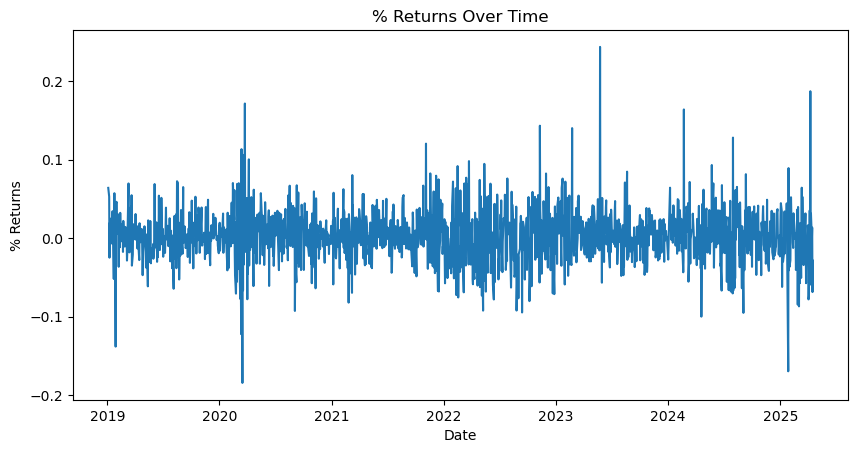

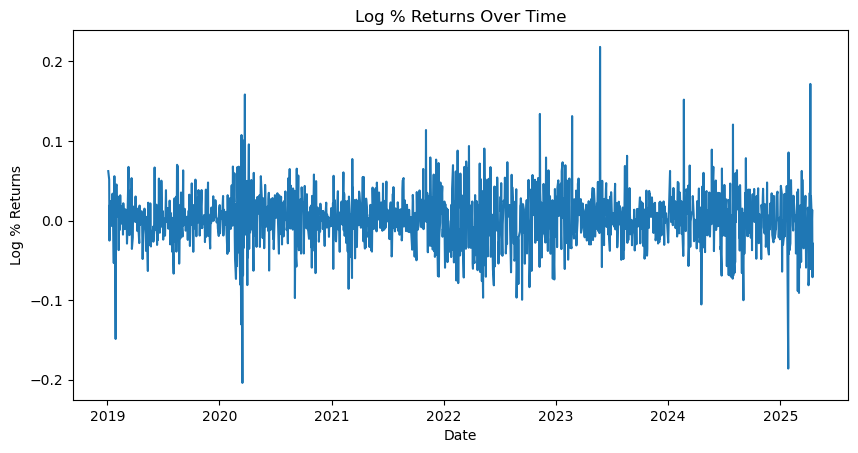

In [802]:
# Plot the % returns over time.

def plot_stock_returns(df: pd.DataFrame) -> None:
    """Plot the historical stock returns for a given ticker.

    Args:
        df (pd.DataFrame): DataFrame containing stock price data.
    """
    ######################
    df['daily_returns'] = df['Close'].pct_change()
    plt.figure(figsize=(10,4.8))
    plt.plot(df['Date'], df['daily_returns'])
    plt.title("% Returns Over Time")
    plt.xlabel("Date")
    plt.ylabel("% Returns")
    plt.show()
    ######################

# Plot the returns of the stock. This should be a simple one-liner which uses the previous function.

######################
plot_stock_returns(nvda)
######################


# Plot the log % returns over time.
# Use Matplotlib.

def plot_log_returns(df: pd.DataFrame) -> None:
    """Calculate and plot the log % returns of stock prices for a given ticker.

    Args:
        df (pd.DataFrame): DataFrame containing stock price data.
    """
    ######################
    df['log_daily_returns'] = np.log(df['Close'] / df['Close'].shift(1))
    plt.figure(figsize=(10,4.8))
    plt.plot(df['Date'], df['log_daily_returns'])
    plt.title("Log % Returns Over Time")
    plt.xlabel("Date")
    plt.ylabel("Log % Returns")
    plt.show()
    ######################

# Plot the log returns of the stock. This should be a simple one-liner which uses the previous function.

######################
plot_log_returns(nvda)
######################

# Exploratory Data Analysis (EDA)

## **Technical Indicator Calculations**

Price                      Date       Close     Volume  daily_returns  \
1578  2025-04-11 00:00:00+00:00  110.930000  313417300       0.031235   
1579  2025-04-14 00:00:00+00:00  110.709999  264705000      -0.001983   
1580  2025-04-15 00:00:00+00:00  112.199997  228966900       0.013459   
1581  2025-04-16 00:00:00+00:00  104.489998  397016900      -0.068717   
1582  2025-04-17 00:00:00+00:00  101.489998  290833400      -0.028711   

Price  log_daily_returns  rolling_mean        rsi  
1578            0.030758      110.8750  43.104779  
1579           -0.001985      110.4340  44.194314  
1580            0.013369      110.2725  47.798226  
1581           -0.071192      109.6210  41.750034  
1582           -0.029131      108.7690  39.476286  


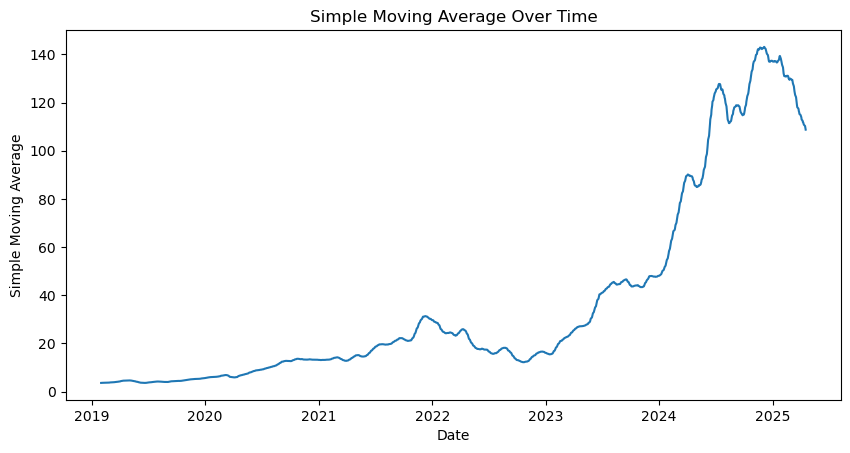

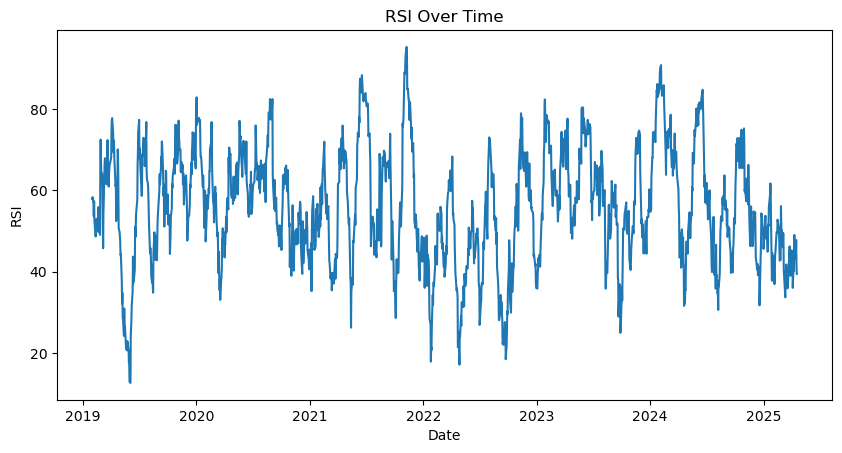

In [805]:
# Compute and plot the rolling mean and relative strength index (RSI) of a stock over a given window size.
# A rolling mean (simple moving average) smooths out short-term fluctuations.
# RSI measures the speed and magnitude of price changes.
# RSI Formula:
# RSI = 100 - [ 100 / (1 + RS) ]
# where RS = (Average Gain over the period) / (Average Loss over the period)

def calculate_technical_indicators(df: pd.DataFrame, window: int) -> pd.DataFrame:
    """Calculate technical indicators such as Moving Average and RSI for a given time window.

    Args:
        df (pd.DataFrame): DataFrame containing stock price data.
        window (int): Time window for indicator calculations.

    Returns:
        (pd.DataFrame): DataFrame containing moving average and RSI values as Pandas Series.
    """
    ######################
    df['rolling_mean'] = df['Close'].rolling(window).mean()
    
    
    close_delta = df['Close'].diff()
    delta_sign = np.sign(close_delta)
    
    df['up_moves'] = np.where(delta_sign > 0, close_delta, 0)
    df['down_moves'] = np.where(delta_sign < 0, close_delta.abs(), 0)

    avg_u = df['up_moves'].rolling(window).mean()
    avg_d = df['down_moves'].rolling(window).mean()

    rs = avg_u / avg_d
    rsi = 100 - (100 / (1 + rs))
    df['rsi'] = rsi

    df.drop(columns=['up_moves','down_moves'], inplace=True)
    
    print(df.tail())
    ######################


######################
calculate_technical_indicators(nvda, 20)

plt.figure(figsize=(10,4.8))
plt.plot(nvda['Date'], nvda['rolling_mean'])
plt.title("Simple Moving Average Over Time")
plt.xlabel("Date")
plt.ylabel("Simple Moving Average")
plt.show()

plt.figure(figsize=(10,4.8))
plt.plot(nvda['Date'], nvda['rsi'])
plt.title("RSI Over Time")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.show()
######################

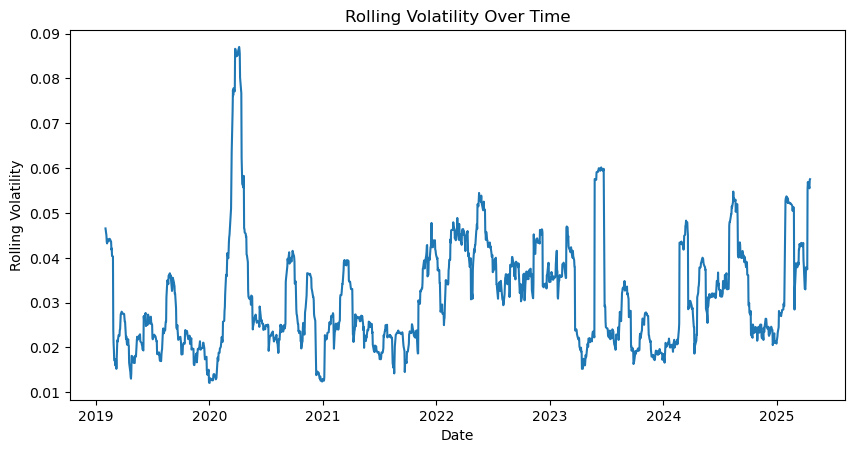

In [806]:
# Compute and plot the rolling volatility of a stock over a given window size

def calculate_rolling_volatility(df: pd.DataFrame, window: int) -> pd.DataFrame:
    """Calculate rolling volatility for a given time window.

    Args:
        df (pd.DataFrame): DataFrame containing stock price data.
        window (int): Time window for indicator calculations.

    Returns:
        (pd.DataFrame): DataFrame containing rolling volatility as Pandas Series.
    """
    #############################
    df['rolling_volatility'] = df['daily_returns'].rolling(window).std()
    #############################

######################
calculate_rolling_volatility(nvda, 20)

plt.figure(figsize=(10,4.8))
plt.plot(nvda['Date'], nvda['rolling_volatility'])
plt.title("Rolling Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Rolling Volatility")
plt.show()
######################

## **Stock Comparisons**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


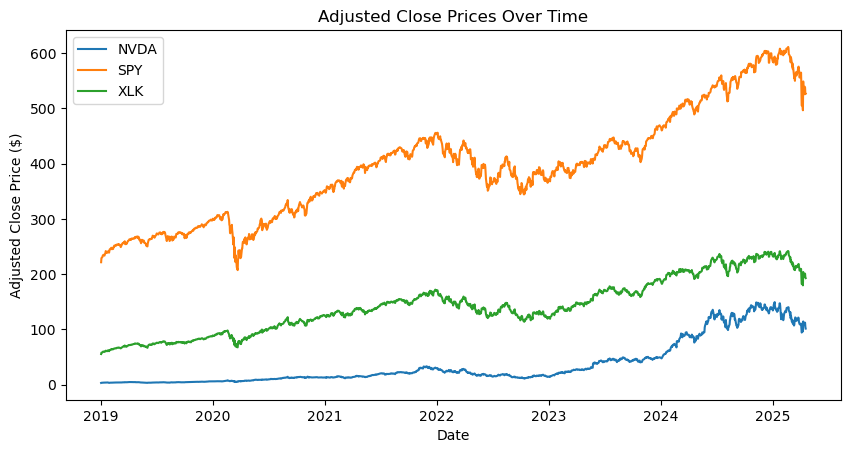

In [808]:
# Compare Nvidia returns to the S&P 500 returns and XLK (Technology Sector ETF) returns

nvda_only_close = nvda[['Date', 'Close']].rename(columns={'Close': 'NVDA'})
spy = import_stock_data('SPY', '2019-01-01', '2025-04-20')[['Date','Close']].rename(columns={'Close': 'SPY'})
xlk = import_stock_data('XLK', '2019-01-01', '2025-04-20')[['Date','Close']].rename(columns={'Close': 'XLK'})

combined = pd.merge(nvda_only_close, spy, on='Date')
combined = pd.merge(combined, xlk, on='Date')
combined.head()

plt.figure(figsize=(10,4.8))
plt.plot(combined['Date'], combined['NVDA'], label='NVDA')
plt.plot(combined['Date'], combined['SPY'], label='SPY')
plt.plot(combined['Date'], combined['XLK'], label='XLK')
plt.title("Adjusted Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price ($)")
plt.legend()
plt.show()

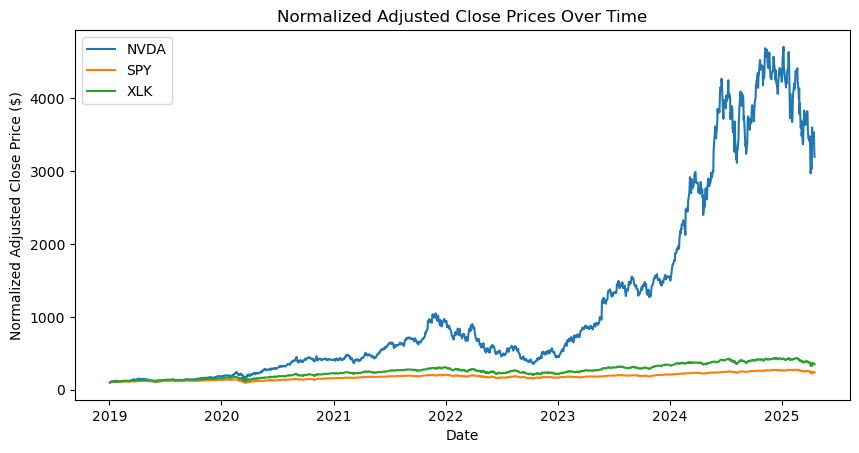

In [809]:
# Normalized comparison of Nvidia, S&P 500, and Technology Sector performance over time

normalized = combined.copy()
normalized[['NVDA', 'SPY', 'XLK']] = normalized[['NVDA', 'SPY', 'XLK']] / normalized[['NVDA', 'SPY', 'XLK']].iloc[0] * 100

plt.figure(figsize=(10,4.8))
plt.plot(normalized['Date'], normalized['NVDA'], label='NVDA')
plt.plot(normalized['Date'], normalized['SPY'], label='SPY')
plt.plot(normalized['Date'], normalized['XLK'], label='XLK')
plt.title("Normalized Adjusted Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Adjusted Close Price ($)")
plt.legend()
plt.show()


## **Correlation Calculations**
Reference Video: https://www.youtube.com/watch?v=e_c3aw8LMBw

In [811]:
# Correlation between Nvidia, S&P 500, and Technology Sector performance over time

returns = combined.copy()
returns['NVDA_ret'] = combined['NVDA'].pct_change()
returns['SPY_ret'] = combined['SPY'].pct_change()
returns['XLK_ret'] = combined['XLK'].pct_change()
returns = returns.drop(columns=['NVDA', 'SPY', 'XLK', 'Date'])
returns = returns.dropna()

returns = returns.rename(columns={'NVDA_ret': 'NVDA'})
returns = returns.rename(columns={'SPY_ret': 'SPY'})
returns = returns.rename(columns={'XLK_ret': 'XLK'})

# Correlation matrix
corr_matrix = returns.corr()
corr_matrix


Price,NVDA,SPY,XLK
Price,,,
NVDA,1.000000,0.701882,0.813295
SPY,0.701882,1.000000,0.935229
XLK,0.813295,0.935229,1.000000


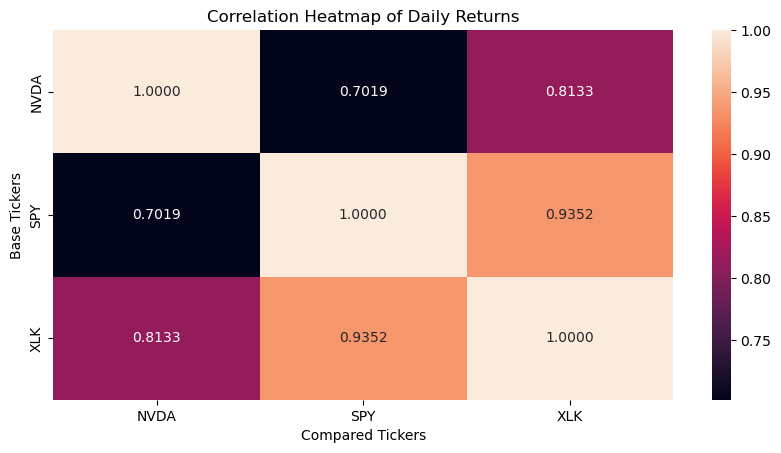

In [812]:
# Heatmap of correlations
sns.heatmap(corr_matrix, annot=True, fmt='.4f')
plt.xlabel('Compared Tickers')
plt.ylabel('Base Tickers')
plt.title('Correlation Heatmap of Daily Returns');

In [813]:
# Volatility and Beta Calculations

# Daily and annual volatility calculations
vol_daily = returns.std()
vol_annual = vol_daily * np.sqrt(252)

# Beta calculations (compared to the S&P 500)
beta = {
    'NVDA': returns['NVDA'].cov(returns['SPY']) / returns['SPY'].var(),
    'XLK':  returns['XLK'].cov(returns['SPY']) / returns['SPY'].var(),
    'SPY':  1.0
}

# Dictionary containing volatility and beta values
vol_and_beta = {
    'Daily Volatility': vol_daily.to_dict(),
    'Annualized Volatility': vol_annual.to_dict(),
    'Beta to SPY': beta
}

vol_and_beta_df = pd.DataFrame(vol_and_beta).round(4)
vol_and_beta_df.reindex(['NVDA', 'XLK', 'SPY'])

,Daily Volatility,Annualized Volatility,Beta to SPY
NVDA,0.0335,0.5316,1.8277
XLK,0.0172,0.2735,1.2529
SPY,0.0129,0.2042,1.0000


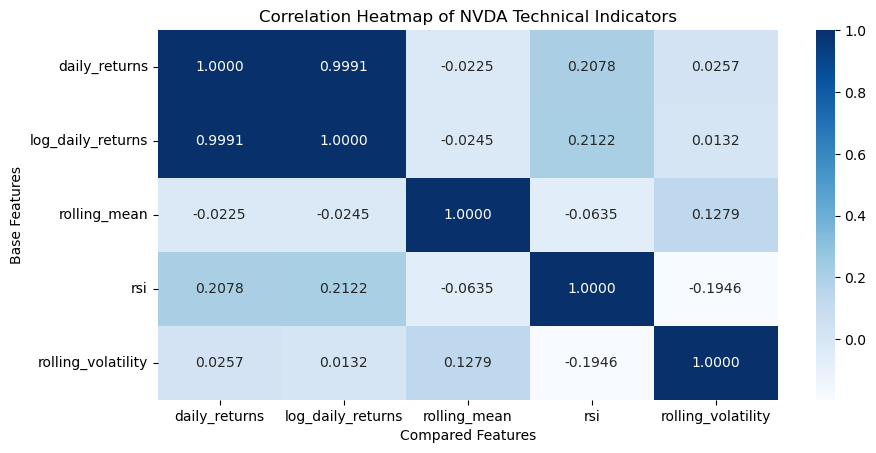

In [814]:
# Correlation between features of NVDA stock prices

# Correlation Matrix
feature_map = nvda[['daily_returns', 'log_daily_returns', 'rolling_mean', 'rsi', 'rolling_volatility']]
corr_matrix = feature_map.corr()
corr_matrix

# Heatmap of correlations
sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='Blues')
plt.xlabel('Compared Features')
plt.ylabel('Base Features')
plt.title('Correlation Heatmap of NVDA Technical Indicators');

## **Autocorrelation**
Reference Video: https://www.youtube.com/watch?v=GcJ__g_cimA

<Figure size 1000x480 with 0 Axes>

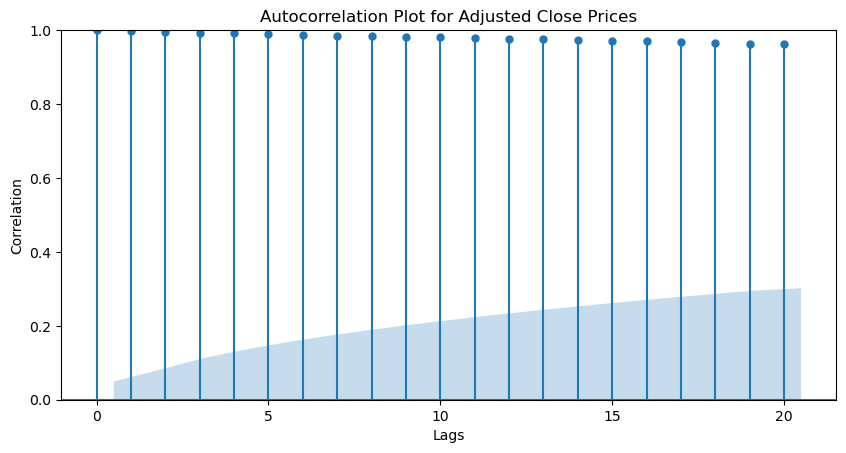

In [816]:
# Autocorrelation of stock prices

plt.figure(figsize=(10,4.8))
plot_acf(nvda['Close'].dropna(), lags=20)
plt.ylim(0,1)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Autocorrelation Plot for Adjusted Close Prices')
plt.show()

<Figure size 1000x480 with 0 Axes>

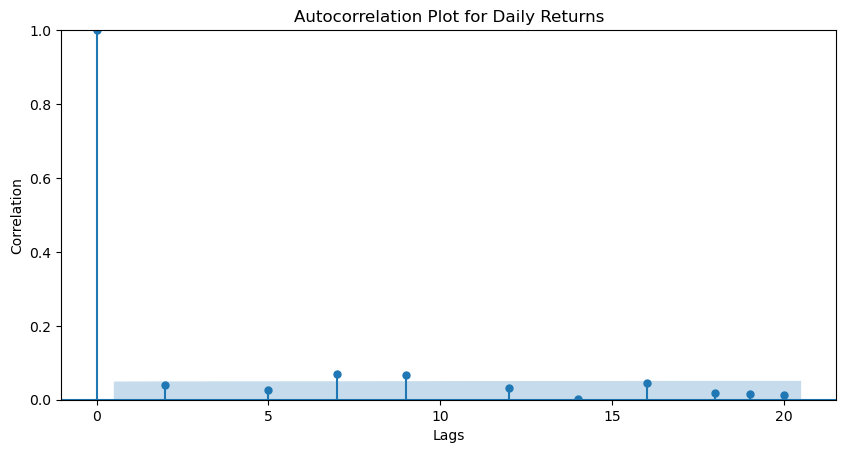

In [817]:
# Autocorrelation of daily_returns

plt.figure(figsize=(10,4.8))
plot_acf(nvda['daily_returns'].dropna(), lags=20)
plt.ylim(0,1)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Autocorrelation Plot for Daily Returns')
plt.show()

<Figure size 1000x480 with 0 Axes>

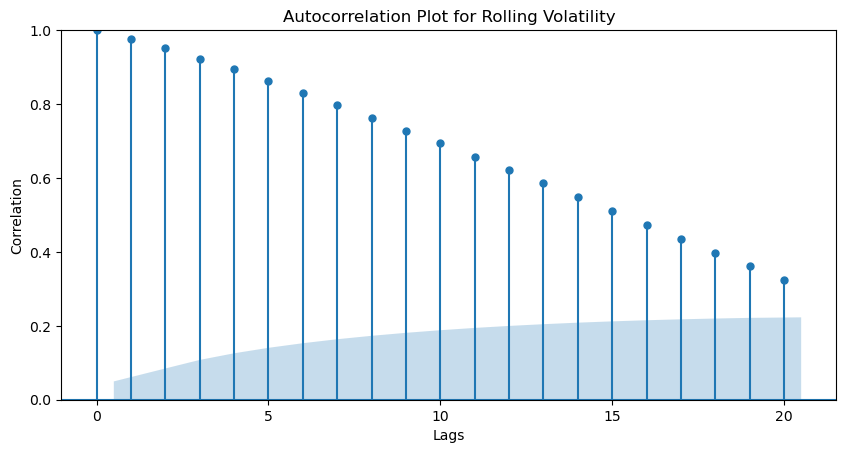

In [818]:
# Autocorrelation of rolling volatility

plt.figure(figsize=(10,4.8))
plot_acf(nvda['rolling_volatility'].dropna(), lags=20)
plt.ylim(0,1)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title('Autocorrelation Plot for Rolling Volatility')
plt.show()

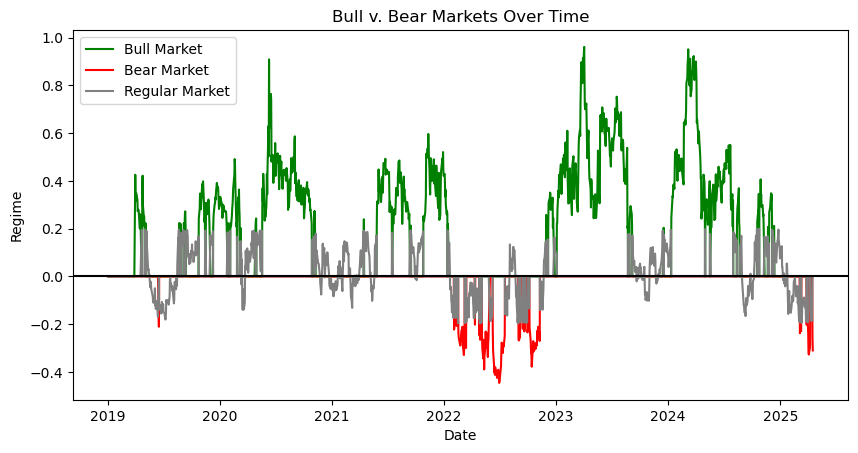

In [819]:
# Bull/Bear Markets

market_trends = nvda.copy()

# Classify bull (over 20% returns) and bear (under 20% returns) markets
close_delta = market_trends['Close'].pct_change(periods=60)
market_trends['bull'] = np.where(close_delta >= 0.2, close_delta, 0)
market_trends['bear'] = np.where(close_delta <= -0.2, close_delta, 0)
market_trends['normal'] = np.where((close_delta < 0.2) & (close_delta > -0.2), close_delta, 0)

plt.figure(figsize=(10,4.8))
plt.plot(market_trends['Date'], market_trends['bull'], label='Bull Market', color='green')
plt.plot(market_trends['Date'], market_trends['bear'], label='Bear Market', color='red')
plt.plot(market_trends['Date'], market_trends['normal'], label='Regular Market', color='gray')
plt.axhline(0, color='black')
plt.title("Bull v. Bear Markets Over Time")
plt.xlabel("Date")
plt.ylabel("Regime")
plt.legend()
plt.show()

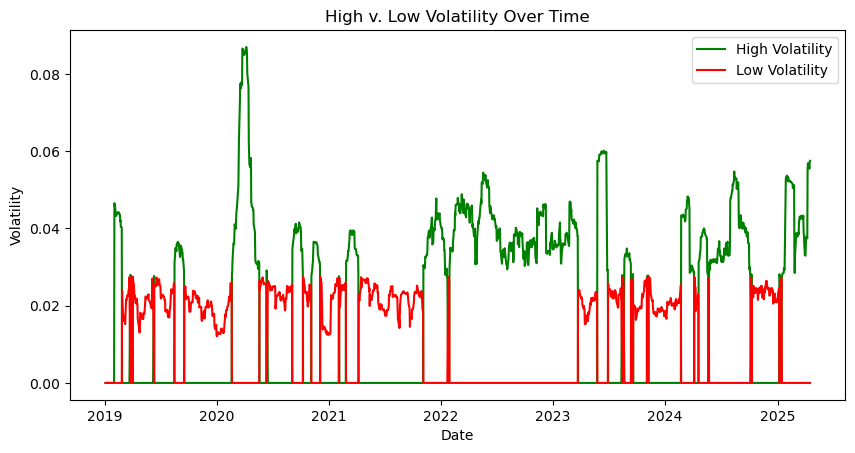

In [820]:
# Volatility Clusters

vol_trends = nvda.copy()
vol_trends['rolling_volatility'] = vol_trends['daily_returns'].rolling(window=20).std()
vol_trends.dropna()
threshold = vol_trends['rolling_volatility'].median()

# Classify high (over the median volatility for the window) or low (under the median volatility for the window) volatility
vol_trends['high_vol'] = np.where(vol_trends['rolling_volatility'] >= threshold, vol_trends['rolling_volatility'], 0)
vol_trends['low_vol'] = np.where(vol_trends['rolling_volatility'] <= threshold, vol_trends['rolling_volatility'], 0)

plt.figure(figsize=(10,4.8))
plt.plot(vol_trends['Date'], vol_trends['high_vol'], label='High Volatility', color='green')
plt.plot(vol_trends['Date'], vol_trends['low_vol'], label='Low Volatility', color='red')
plt.title("High v. Low Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# Statistical Modeling/Forecasting

## **Geometric Brownian Motion**
Reference Video: https://www.youtube.com/watch?v=6mi7vCaIgdU

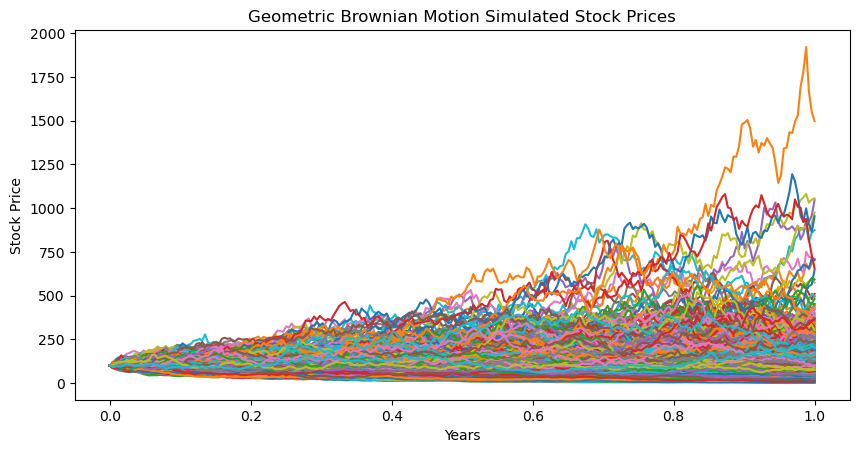

In [823]:
# Parameters for stock price simulation

log_returns = np.log(nvda['Close']/nvda['Close'].shift(1))
volatility = log_returns.rolling(window=20).std() * np.sqrt(252)

S0 = nvda['Close'].iloc[-1]  # Initial stock price
mu = 0.05  # Expected return
sigma = volatility.iloc[-1] # Volatility
T = 1  # Time horizon (1 year)
dt = 1/252  # Time step (daily)
n = int(T/dt)  # Number of time steps (252 days)



# Simulating stock prices with Numpy using GBM across 100 trials

# Geometric Brownian Motion (GBM) model for a stock price S(t):
# dS(t) = mu * S(t) * dt + sigma * S(t) * dW(t)
# Discretized version (Euler-Maruyama):
# S(t+dt) = S(t) * exp((mu - 0.5 * sigma^2) * dt + sigma * sqrt(dt) * Z)
# where Z ~ N(0,1) is a standard normal random variable.

def simulate_gbm_stock_prices(S0: float, mu: float, sigma: float, T: float, dt: float, n: int) -> np.ndarray:
    """Simulate stock prices using Geometric Brownian Motion (GBM) over multiple trials.

    Args:
        S0 (float): Initial stock price.
        mu (float): Expected return.
        sigma (float): Volatility of the stock.
        T (float): Total time duration.
        dt (float): Time step.
        n (int): Number of simulation trials.

    Returns:
        np.ndarray: Simulated stock price paths.
    """
    ######################
    St = np.exp(
        (mu - sigma ** 2 / 2) * dt
        + sigma * np.random.normal(0, np.sqrt(dt), size=(1000, n)).T
    )
    St = np.vstack([np.ones(1000), St])
    St = S0 * St.cumprod(axis=0)

    return St
    ######################

# Now, plot simulated stock prices.

######################
time = np.linspace(0, T, n + 1)
tt = np.full(shape=(1000, n + 1), fill_value = time).T
plt.plot(tt, simulate_gbm_stock_prices(S0, mu, sigma, T, dt, n))
plt.xlabel("Years")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion Simulated Stock Prices")
plt.show()
######################

## **PCA Model**
Reference Article: https://medium.com/@heyamit10/principal-component-analysis-in-stock-price-prediction-2a7407f2df25

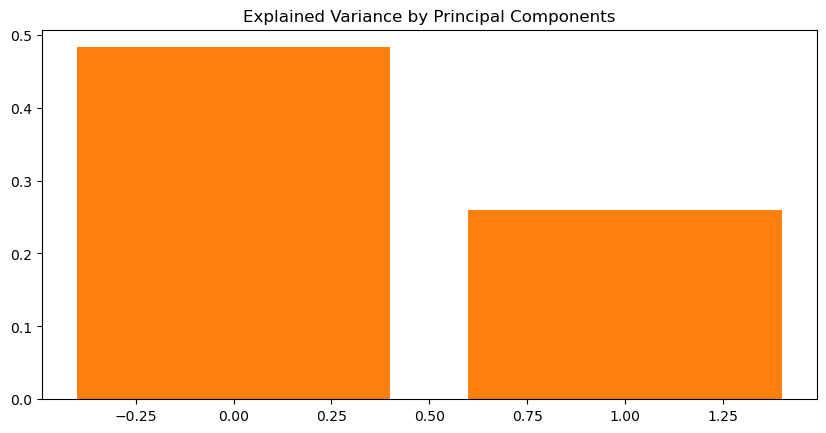

MSE with PCA: 72.8507
MSE without PCA: 16.5684
Performance with PCA: 72.8507
Performance without PCA: 16.5684


In [825]:
# PCA Model

#pca_nvda = import_stock_data('NVDA', '2019-01-01', '2025-04-20')
pca_nvda = nvda.copy()
pca_nvda['SMA_20'] = pca_nvda['Close'].rolling(window=20).mean()
pca_nvda['SMA_50'] = pca_nvda['Close'].rolling(window=50).mean()
pca_nvda['Volatility'] = pca_nvda['Close'].rolling(window=20).std()
pca_nvda.dropna(inplace=True)

# Select features to be analyzed and normalize
features = pca_nvda[['SMA_20', 'SMA_50', 'Volatility', 'daily_returns', 'log_daily_returns', 'rolling_mean', 'rsi', 'rolling_volatility']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Number of features to be chosen
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Plot variance explained by each principal component
explained_variance = pca.explained_variance_ratio_
plt.bar(range(len(explained_variance)), explained_variance)
plt.bar(range(len(explained_variance)), explained_variance)
plt.title('Explained Variance by Principal Components')
plt.show()

# Use principal components as predictors and 'Close' price as target
X = principal_components
y = pca_nvda['Close']

# Split once using original (scaled) data
X_train_full, X_test_full, y_train, y_test = train_test_split(scaled_features, y, test_size=0.2, random_state=42)

# Then apply PCA only to X values
X_train_pca = pca.transform(X_train_full)
X_test_pca = pca.transform(X_test_full)

# Model with PCA
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)
mse_pca = mean_squared_error(y_test, y_pred_pca)

# Model without PCA
model_raw = LinearRegression()
model_raw.fit(X_train_full, y_train)
y_pred_raw = model_raw.predict(X_test_full)
mse_raw = mean_squared_error(y_test, y_pred_raw)

# Output results
print(f'MSE with PCA: {mse_pca:.4f}')
print(f'MSE without PCA: {mse_raw:.4f}')


print(f'Performance with PCA: {mse_pca:.4f}')
print(f'Performance without PCA: {mse_raw:.4f}')

## **Logistic Regression**
Reference Article: https://medium.com/@deepml1818/stock-price-prediction-with-logistic-regression-e80ad38db54a

In [827]:
# Logistic Regression

# Load and filter data
logistic_nvda = import_stock_data('NVDA', '2019-01-01', '2025-04-20')
logistic_nvda_filter = logistic_nvda['Close'].pct_change() * 100
logistic_nvda_filter = logistic_nvda_filter.rename('Today')
logistic_nvda_filter = logistic_nvda_filter.reset_index()

logistic_nvda_filter['Volume'] = logistic_nvda['Volume'].shift(1).values / 1000_000_000

# Create lag features from past 5 days of returns
for i in range(1,6):
    logistic_nvda_filter['Lag ' + str(i)] = logistic_nvda_filter['Today'].shift(i)

logistic_nvda_filter = logistic_nvda_filter.dropna()

# Determine direction of stock movement
logistic_nvda_filter['Direction'] = [1 if i > 0 else 0 for i in logistic_nvda_filter['Today']]

# Define feature matrix X and target variable Y
X = logistic_nvda_filter[['Lag 1', 'Lag 2', 'Lag 3', 'Lag 4', 'Lag 5', 'Volume']]
Y = logistic_nvda_filter['Direction']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train logistic regression
clf = LogisticRegression().fit(X_train, y_train)

# Evaluate model accuracy
clf.score(X_test, y_test)

[*********************100%***********************]  1 of 1 completed


0.5253164556962026

## **LASSO Regression**
Reference Article: https://swngui.medium.com/python-tutorial-using-lasso-to-predict-stock-prices-ee71f82aa698

In [829]:
# LASSO Regression

# Load data
lass_nvda = import_stock_data('NVDA', '2019-01-01', '2025-04-20')

# Create the feature matrix
X = lasso_nvda.drop(columns=['Close', 'Date'], errors='ignore')


# Create the target variable vector
y = lasso_nvda['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Lasso model
lasso = Lasso(alpha=0.1, max_iter=10000)

# Train the model
lasso.fit(X_train, y_train)

# Make predictions on test set
y_pred = lasso.predict(X_test)

# Calculate the MSE
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)

[*********************100%***********************]  1 of 1 completed

Mean Squared Error: 0.4382176667141769


## **ARIMA Model**

Reference Article: https://medium.com/@shikharkanaskar97/predicting-stock-prices-using-arima-fourier-transformation-and-deep-learning-e5fb4f693c85

[*********************100%***********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6575.156, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6609.475, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6591.282, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6594.320, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6609.071, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6574.987, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6583.855, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6573.860, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6582.310, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6579.794, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6573.700, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6594.310, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6591.295, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6574.764, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]          

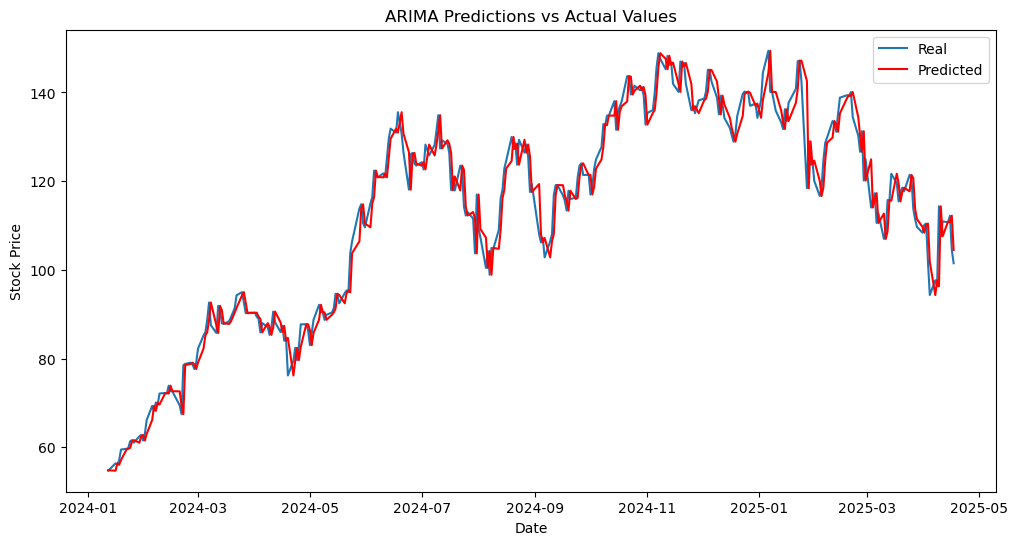

AIC: 6573.6999
BIC: 6589.7993
RMSE: 4.1590
MAE: 3.0281


In [831]:
# ARIMA Model 

# Load and filter data
arima_nvda = import_stock_data('NVDA', '2019-01-01', '2025-04-20')

arima_nvda = arima_nvda.reset_index()
arima_nvda['Date'] = pd.to_datetime(arima_nvda['Date'])
arima_nvda.set_index('Date', inplace=True)
arima_nvda = arima_nvda['Close'].to_frame()

# Select best ARIMA order and fit model
model = auto_arima(arima_nvda['Close'], seasonal=False, trace=True)
print(model.summary())

# ARIMA forecasting
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split dataset into training and testing data
X = arima_nvda.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Forecasting
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

# Plot ARIMA predictions against actual stock price values
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(arima_nvda.iloc[size:,:].index, test, label='Real')
plt.plot(arima_nvda.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Calculate Evaluation metrics
aic = model.aic()
bic = model.bic()
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)


evaluation_metrics = {
    'AIC': aic, 
    'BIC': bic,
    'RMSE': rmse,
    'MAE': mae
}

for name, value in evaluation_metrics.items():
    print(f"{name}: {value:.4f}")

## **GARCH Model**
Reference Article: https://medium.com/@sheikh.sahil12299/mastering-volatility-forecasting-with-garch-models-a-deep-dive-into-financial-market-dynamics-8df73c037b7e

[*********************100%***********************]  1 of 1 completed

Daily volatility:  3.35%
Monthly volatility:  15.36%
Annual volatility:  53.20%


mu          0.338869
omega       0.725284
alpha[1]    0.103953
beta[1]     0.836013
Name: params, dtype: float64


            h.1        h.2        h.3       h.4        h.5
1582  27.450298  26.527625  25.660344  24.84513  24.078856


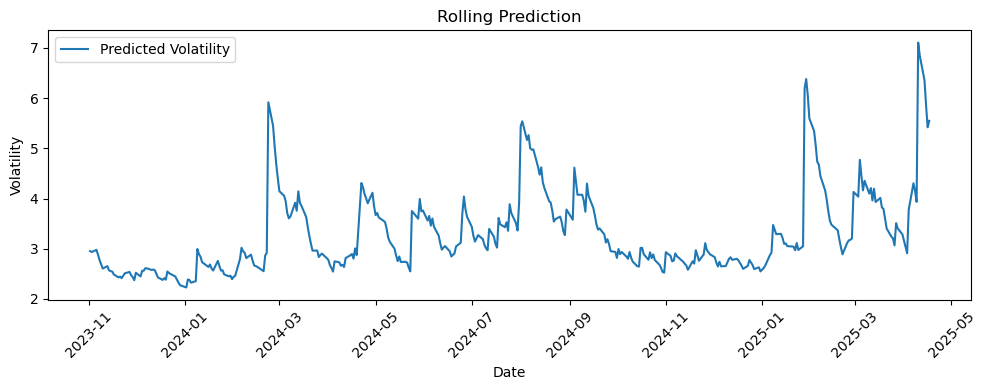

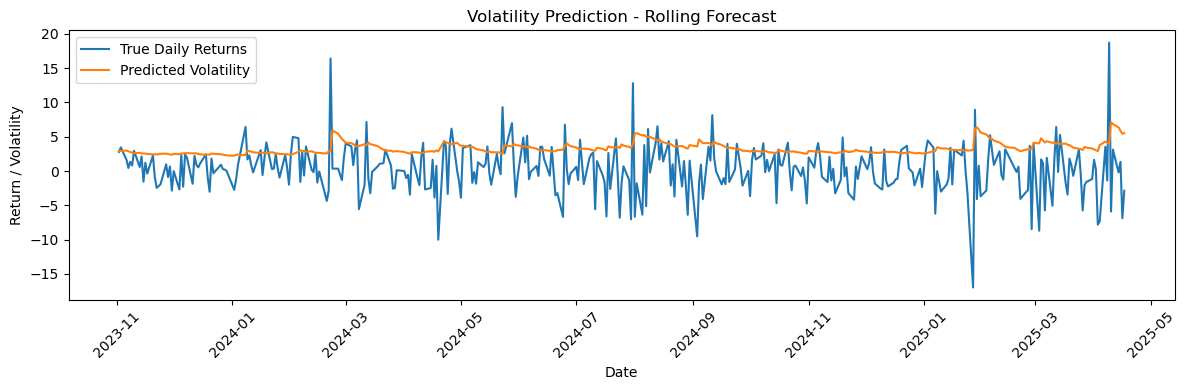

In [833]:
# GARCH Model

# Load and filter data
garch_nvda = import_stock_data('NVDA', '2019-01-01', '2025-04-20')
garch_nvda['Return'] = garch_nvda['Close'].pct_change() * 100
garch_nvda.dropna(inplace=True)

# Calculate daily, monthly, and annual volatilities
daily_volatility = garch_nvda['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))
monthly_volatility = math.sqrt(21) * daily_volatility
print('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))
annual_volatility = math.sqrt(252) * daily_volatility
print('Annual volatility: ', '{:.2f}%'.format(annual_volatility))
print('\n')

# Fit GARCH model to returns
garch_model = arch_model(garch_nvda['Return'], p=1, q=1, mean='constant', vol='GARCH', dist='normal')
gm_result = garch_model.fit(disp='off')
print(gm_result.params)
print('\n')
gm_forecast = gm_result.forecast(horizon=5)
print(gm_forecast.variance[-1:])

# Rolling forecasts
rolling_predictions = []
test_size = 365
for i in range(test_size):
 train = garch_nvda['Return'][:-(test_size-i)]
 model = arch_model(train, p=1, q=1)
 model_fit = model.fit(disp='off')
 pred = model_fit.forecast(horizon=1)
 rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
rolling_predictions = pd.Series(rolling_predictions, index=garch_nvda['Return'].index[-365:])


# Plot rolling volatility predictions
plt.figure(figsize=(10, 4))
plt.plot(garch_nvda['Date'][-365:], rolling_predictions.values, label='Predicted Volatility')
plt.title('Rolling Prediction')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Plot rolling volatility predictions over true daily returns
plt.figure(figsize=(12, 4))
plt.plot(garch_nvda['Date'][-365:], garch_nvda['Return'][-365:], label='True Daily Returns')
plt.plot(garch_nvda['Date'][-365:], rolling_predictions.values, label='Predicted Volatility')
plt.title('Volatility Prediction - Rolling Forecast')
plt.xlabel('Date')
plt.ylabel('Return / Volatility')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
